### Analysis notebook for stark broadening
Brain storming for what we want to do here:
- Analyse Stark broadening with IP320 spectrometers from AEI and AEF
- In special cases also do the analysis using Sopra spectrometers
- save the fitted data not in the git but in the recommended analysis folder
    - save the max channel data
    - save profiles

What not to do here:
- comparisons to other diagnostics should be in it's own script

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import copy
import json
import codecs
import logging
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("divertor_spectroscopy")
logger.setLevel(logging.DEBUG)

from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import datasource_qss
from divertor_spectroscopy import spectrum
from divertor_spectroscopy import wavelength_calibration
#from divertor_spectroscopy import QSS_search
from divertor_spectroscopy import analysis
from divertor_spectroscopy import instrument


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### The following cell is for input

In [11]:
# spectrometer and discharge
pid = "20230118.026" # EJM neon
pid = "20230209.033"#EJM neon
pid = "20230209.034"#EJM neon
pid = "20230209.035"#EJM neon
pid = "20230209.036"#EJM neon
pid = "20230209.037"#EJM neon
pid = "20230323.054"#EJM neon
#pid = "20230209.019#EJM neon"
pid = "20230125.025" # DBM density ramp
#pid = "20230125.043" # DBM neon something
pid = "20230125.045" # DBM density ramp with neon
pid = "20230222.015" # kkm neon
#pid = "20230315.053" # Marcin KKM, 2 - 11.5, control coiils?
#pid = "20230315.054" # Marcin KKM, 2 - 16, control coiils?
#pid = "20230315.055" # Marcin KKM, 2 - 16, control coiils?
#pid = "20230315.056" # Marcin KKM, 2 - 16, control coiils?
#pid = "20230315.057" # Marcin KKM, 2 - 16, control coiils?
#pid = "20230214.038" # Sergey KKM, 1 - 8 s, low density
#pid = "20230214.055" # Sergey KKM, 1 - 8 s, higher density
#pid = "20230214.045" # Sergey KKM, 4 - 8, NBI
#pid = "20230214.061" # Sergey KKM, 4 - 6.3, NBI crazy detachment
pid = "20230315.059" # Argon detachment
pid = "20230323.032"
pid = "20230118.030"

#pid = "20230117.051" # low density for Nassim
camid = "IP320_3" # this is standard from AEF51 and 405 nm
debug = True
ground_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/"
save_path = ground_path+"discharges/OP2.1/"+pid[:8]+"/"+pid+"/"
with open(save_path+"settings_200_version1.json") as f:
    settings_load = json.load(f)
try:
    experiment_length = settings_load["discharge_length"]
    config = settings_load["config"]
except:
    print("Couldn't read the setup file")
    experiment_length = 1
    config = "???"


# datasource
wcal = False # will use the already existing calibration
wcal_comment = "OP2.1" # will find correct wl calibration automatically
#wcal_comment = None
ical = True
instrument_cal = True #
ical_comment = None # will load ical automatically
central_wavelength = None # rarely the automatic saving of this parameter failed, then you need to go manually
database_path = None # handled automatically
broken_channels = None # handled automatically
instrument_function_mode = "convolution_entire_spectrum"
instrument_function_mode = "gauss"
# wavelength calibration
zeeman=True # use zeeman effect - will slow the code down
stark_density = True
special_tags_model = False # this is relevant if you want to debug pec_lines
exclude_saturation_in_wl_calibration = True
save_wavelength_calibration = True
fit_coefficients=False # fits your first and second wl calibration as these should not change over the chip

# here you 
analysis_start = 0
analysis_end = experiment_length
analysis_step = 0.5 # 

save_fits = True
fontsize =14
show_positions = False
scale = "log"
xlim = None


### This cell will produce secondary data to this input

In [12]:
# datasource
signal_type = "signal_photons"
if signal_type == "signal_counts":
    intensity_label = "Intensity [Counts]"
else:
    intensity_label=r"Intensity [Photons/($\mathrm{m}^2$ nm sr s)]"
if camid == "IP320_2" or camid == "IP320_1":
    port = "AEF51"
if camid == "IP320_3" or camid == "IP320_4":
    port = "AEI51"
if config[0] == "E":
    strikelines = ["horizontal","vertical"]
if config[0] == "K":
    strikelines = ["vertical"]
if config[0] == "D":
    strikelines = ["horizontal"]
exclude_channels = {}
exclude_channels["horizontal"] = np.arange(16,27)
exclude_channels["vertical"] = np.arange(0,16)
ls = {"horizontal":"-","vertical":"--"}

### QSS datasource:

2024-02-15 19:46:53,842 - divertor_spectroscopy.datasource_qss - WARNING - Attention, saturation occurs during this discharge. You find nans where > 60000.0 counts are found


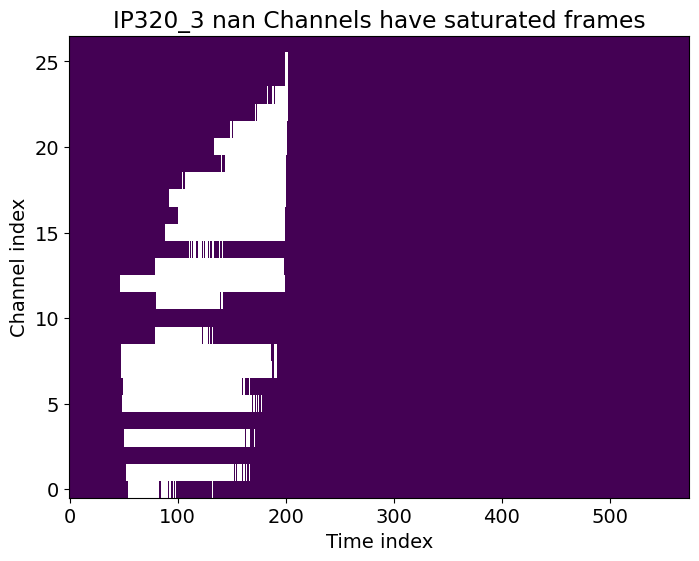

\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\datasource_qss.py:223: RuntimeWarning: Mean of empty slice
  self.data["signal_counts"], (0, 2)), "+-")


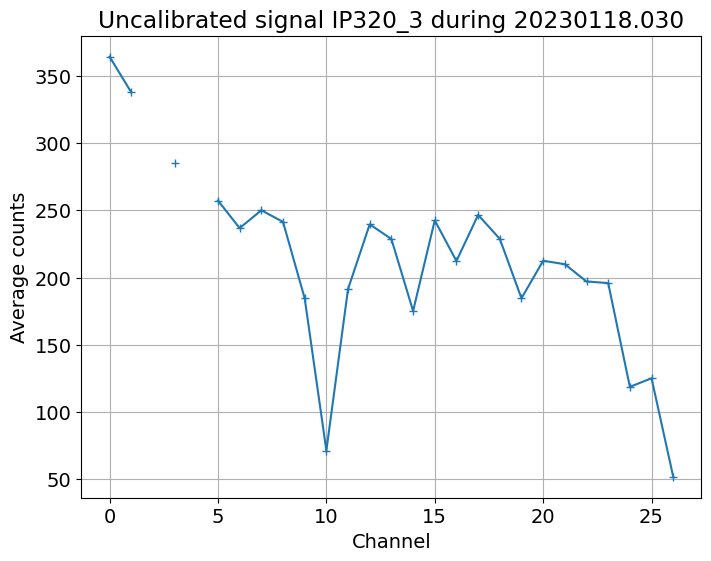

2024-02-15 19:47:18,769 - divertor_spectroscopy.datasource_qss - DEBUG - You need to produce your wavelength vector yourself


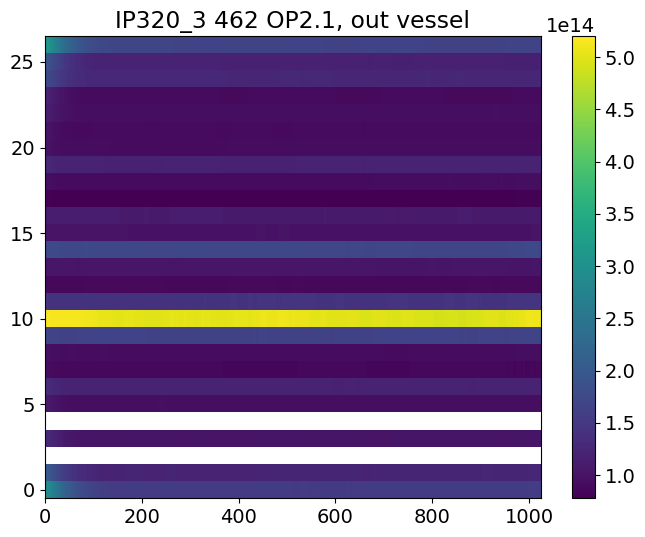

\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\datasource_qss.py:275: RuntimeWarning: Mean of empty slice
  self.data["signal_photons"], (0, 2)), "+-")


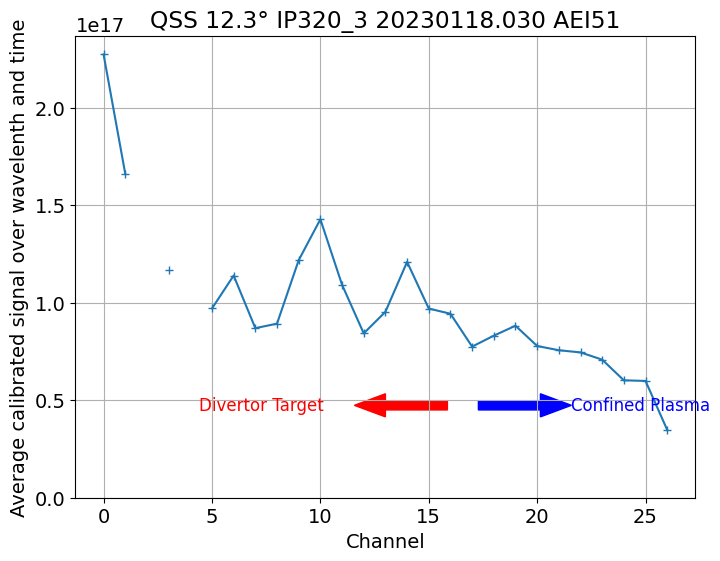

In [13]:
ds_qss = datasource_qss.Datasource_qss(database_path=database_path,time_id=pid,camid=camid,broken_channels=broken_channels,port=port,wcal=wcal,wcal_comment=wcal_comment,ical=ical,ical_comment=ical_comment,instrument_cal=instrument_cal,numeric_instrument_function=True,central_wavelength=central_wavelength,debug=debug)
ds_qss.central_wavelength = int(np.round(ds_qss.metadata["centralWavelength"]))
ds_qss.experiment_length = experiment_length
if ds_qss.central_wavelength == 405:
    strongest_line = 410.174 
    #special_tags = ["NII3s1P_3p1D","NII3d3F_4f1G","NII3d3F_4f3G"]
    if camid == "IP320_1":
        wavelength_coefficients_guess = [404.774651431996, -0.01872106686180723, -2.796893026610617e-07]
        lower_bounds_wl = [404,-0.0195,-1e-6]
        upper_bounds_wl = [406,-0.0185,1e-6]
    if camid == "IP320_2":
        wavelength_coefficients_guess = [404.81573969184533,
                        -0.01871567909500022,
                        -2.847922701865422e-07]#[404.874651431996, -0.01872106686180723, -2.796893026610617e-07]
        lower_bounds_wl = [404,-0.0195,-4e-7]
        upper_bounds_wl = [406,-0.0185,-1e-7]
    if camid == "IP320_4":
        wavelength_coefficients_guess = [404.274651431996, -0.01892106686180723, -2.796893026610617e-07]
        lower_bounds_wl = [403,-0.02,-1e-6]
        upper_bounds_wl = [405,-0.018,1e-6]
if ds_qss.central_wavelength == 364:
    strongest_line = 369.421
    #special_tags = ["NeII3s2D_3p2F","NeII3s4P_3p4P","NeII3s2P_3p2D"] # this will also be displayed in the intensity stuff and debugged in the plots. Maybe this needs refinements!
    #ions = ["NeII"]
    if camid == "IP320_1":
        wavelength_coefficients_guess = [363.8, -0.01915, -3.063141428685387e-07]
        lower_bounds_wl = [362,-0.0195,-1e-6]
        upper_bounds_wl = [366,-0.0185,1e-6]        
    if camid == "IP320_3":
        wavelength_coefficients_guess = [363.8, -0.01915, -3.063141428685387e-07]
        lower_bounds_wl = [362,-0.0195,-1e-6]
        upper_bounds_wl = [366,-0.0185,1e-6]        
if ds_qss.central_wavelength == 462:
    if camid == "IP320_3":
        wavelength_coefficients_guess = [461.85, -0.018, -3.063141428685387e-07]
        lower_bounds_wl = [460,-0.0195,-1e-6]
        upper_bounds_wl = [463,-0.017,1e-6] 

### Load model used for wl calibration using default paramters of model

In [14]:
extra = ""
#extra = "_wavelength_calibration"
model = spectrum.load_model(camid=camid,central_wavelength=ds_qss.central_wavelength,zeeman=zeeman,stark_density=stark_density,extra=extra)

### Wavelength calibration:

\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\wavelength_calibration.py:41: RuntimeWarning: Mean of empty slice
  calibration_spectrum = np.nanmean(spectrum_saturated_frames_excluded,0)
2024-02-15 19:48:23,193 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.604476196125205, 17.091887348381253, 18.428691447533243, 17.324726524347547, 16.612345087514555, 15.409785033601517, 19.444473497504774, 18.0237434705575, 19.19672241923604]
2024-02-15 19:48:23,196 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636, 14.926134211529636]
2024-02-15 19:48:23,197 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.508094627931268, 20.508094627931268, 20.508094627931268, 20.508094627931268, 20.5

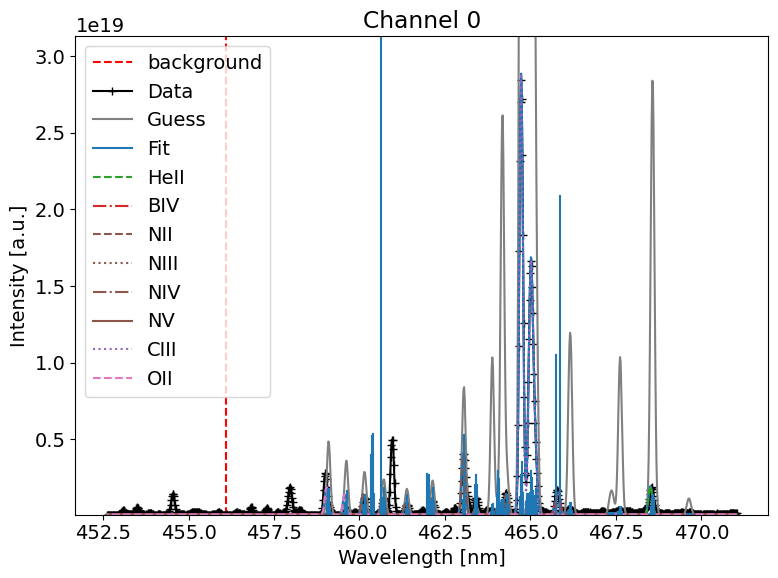

2024-02-15 19:48:31,591 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.429648539955934, 16.726616861190926, 18.302931839974203, 17.2195629086444, 16.616633219741892, 16.074220855893046, 19.21454039106378, 17.75247545739457, 19.052537773534837]
2024-02-15 19:48:31,592 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824, 14.700452881011824]
2024-02-15 19:48:31,593 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766, 20.300561374898766]


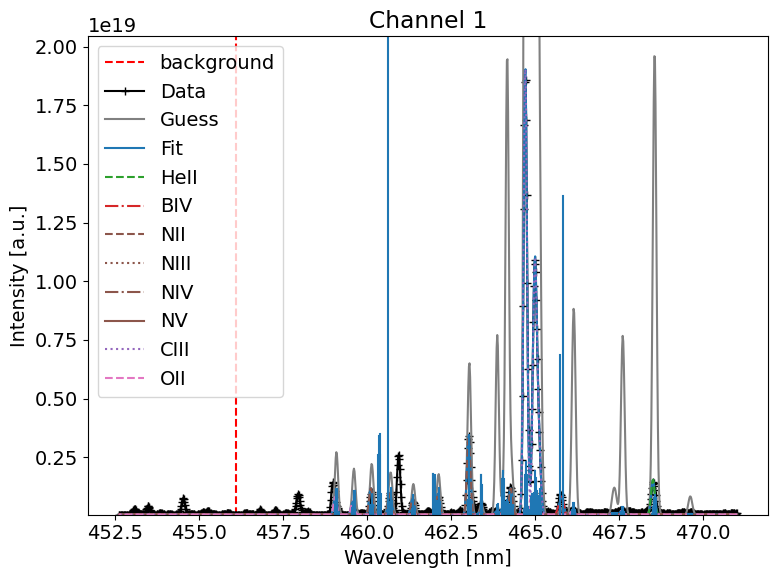

2024-02-15 19:48:47,844 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.205918860071055, 16.353258001100876, 18.054932487233756, 17.085734766399547, 16.638209644162963, 15.9918782916341, 18.95790834839689, 17.401132980320057, 19.03416041044031]
2024-02-15 19:48:47,846 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296, 14.50332698788296]
2024-02-15 19:48:47,847 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603, 20.1643193123603]


Skipping broken channel 2


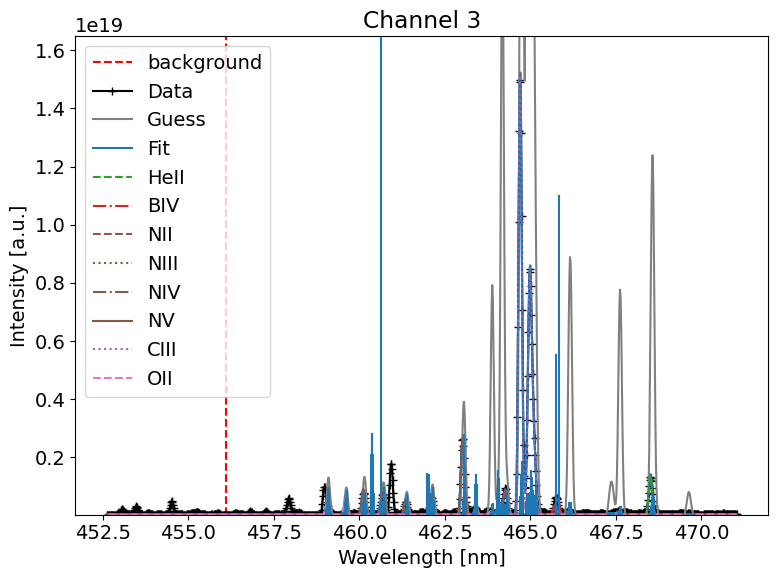

2024-02-15 19:49:03,396 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.01267706095619, 16.085387396790736, 17.840896181424, 17.04150369590268, 16.670338296814023, 15.86323024595436, 18.716206206375332, 17.13639185368203, 19.02593206994246]
2024-02-15 19:49:03,398 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797, 14.379648698570797]
2024-02-15 19:49:03,399 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383, 20.08136564665383]


Skipping broken channel 4


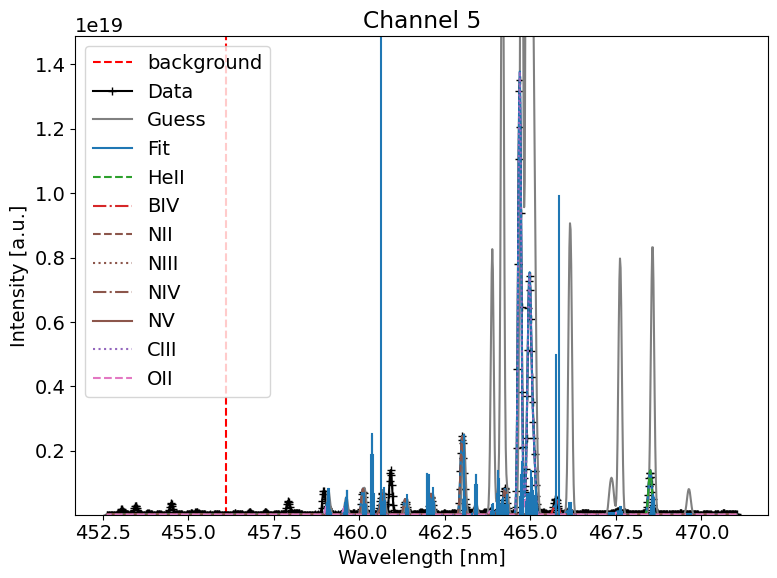

2024-02-15 19:49:14,620 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.018812052516516, 16.074588520161655, 17.80050388421342, 17.13286580115189, 16.73088938056536, 16.071506522039765, 18.739974364415943, 17.12463444631034, 19.149737637118317]
2024-02-15 19:49:14,622 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913, 14.442791991720913]
2024-02-15 19:49:14,623 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868, 20.18029987913868]


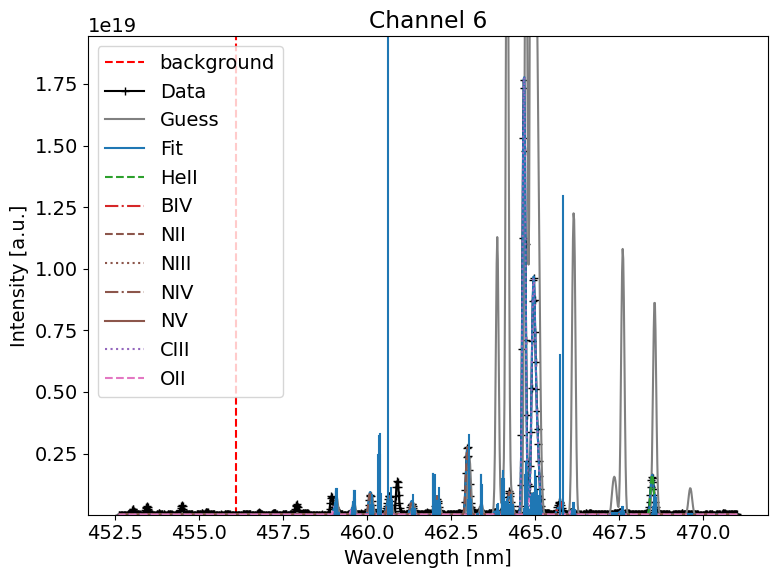

2024-02-15 19:49:22,951 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.770479129288248, 15.78600735265856, 17.466506222943348, 16.926218114920026, 16.61099704533655, 15.835002766241793, 18.386539751340777, 16.81596154070997, 18.922798102701456]
2024-02-15 19:49:22,952 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795, 14.191832506420795]
2024-02-15 19:49:22,953 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762, 19.927266194585762]


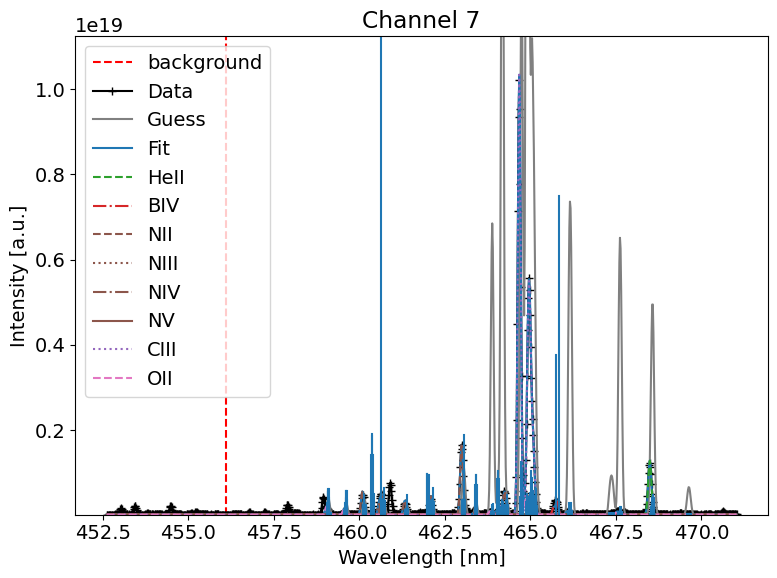

2024-02-15 19:49:30,897 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.82536308902965, 15.815760090439504, 17.410472909844394, 16.90530110206577, 16.592249015953467, 15.83886833597447, 18.385275615023723, 16.836096372982094, 18.948910208061907]
2024-02-15 19:49:30,899 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395, 14.198607533941395]
2024-02-15 19:49:30,900 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128, 19.954549407157128]


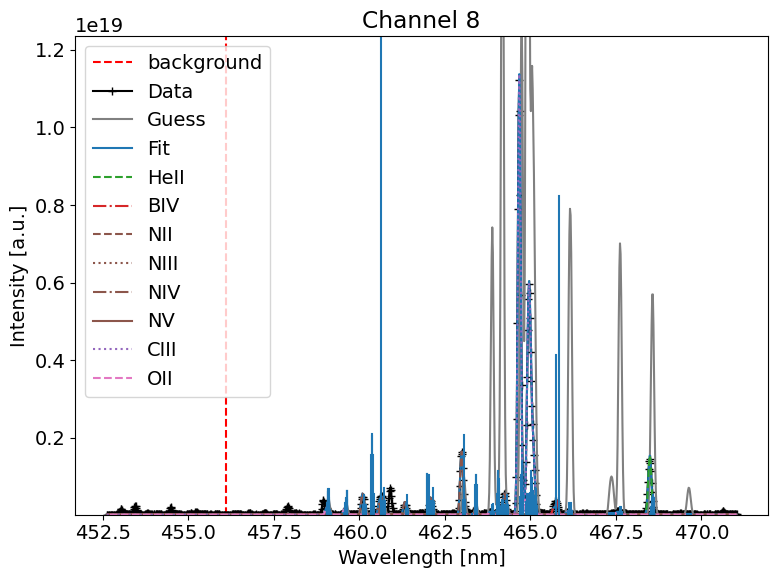

2024-02-15 19:49:38,869 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.936706502218662, 16.15178026141978, 17.446200052056604, 17.163037958892872, 16.60889317065146, 16.108362761207523, 18.692824692046948, 16.97532531127731, 19.343245336821298]
2024-02-15 19:49:38,870 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036, 14.487616707771036]
2024-02-15 19:49:38,871 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536, 20.328531726018536]


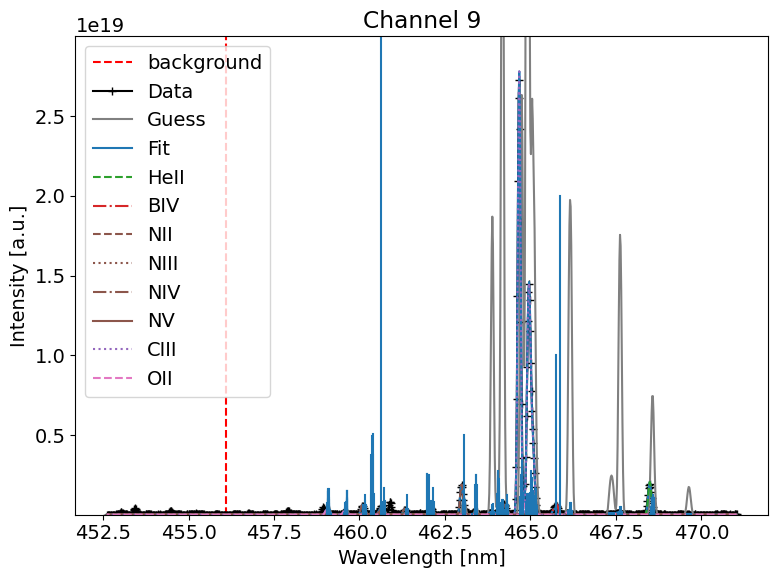

2024-02-15 19:49:47,431 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.04251304885423, 16.294269489083906, 17.422641746473367, 17.204218145428808, 16.65562341513657, 16.445987964975565, 18.72612142687964, 17.09545754605343, 19.441810083943555]
2024-02-15 19:49:47,433 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207, 14.575600595345207]
2024-02-15 19:49:47,434 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824, 20.408415050669824]


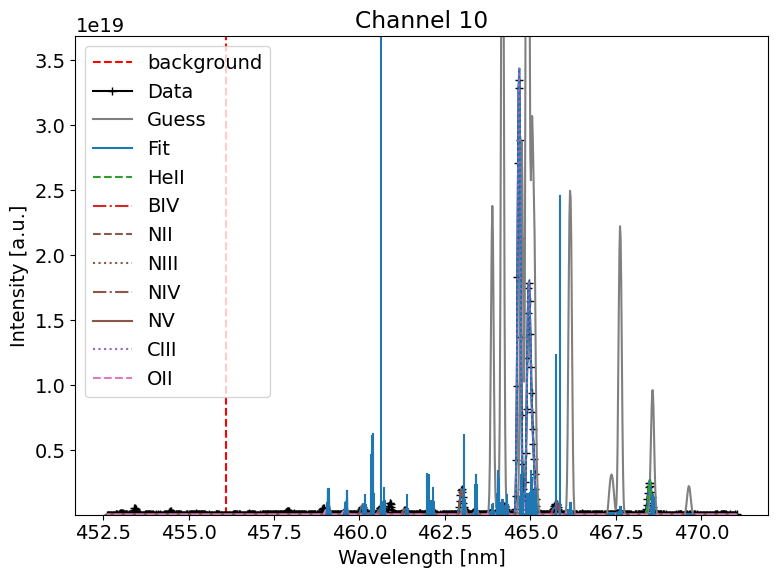

2024-02-15 19:49:55,443 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.933927852064738, 16.112571737175102, 17.345049569210193, 17.086328950376902, 16.57220318668949, 15.915732574593996, 18.576346805352284, 16.822397779587547, 19.27999027368745]
2024-02-15 19:49:55,444 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744, 14.421549688748744]
2024-02-15 19:49:55,446 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701, 20.25697956947701]


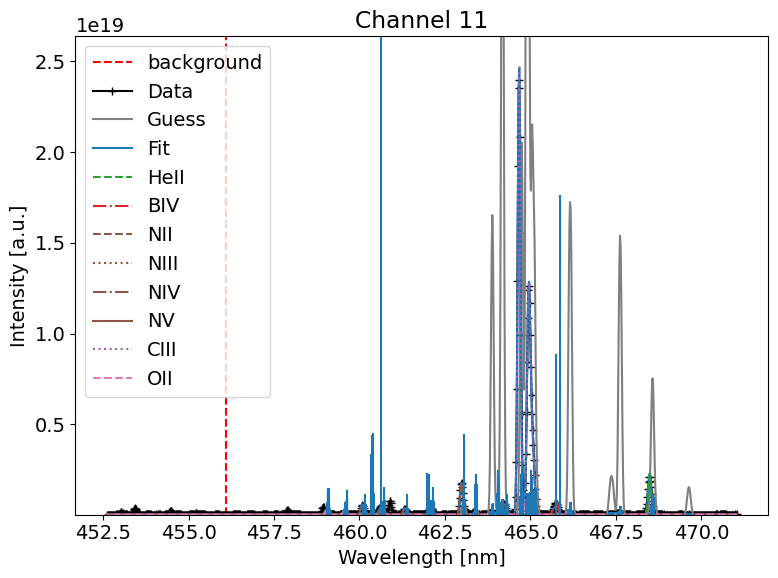

2024-02-15 19:50:03,132 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.3863273353482, 15.564607586259678, 16.793208561357766, 16.54424482042802, 16.400396827374735, 15.80279123934911, 17.849770888157686, 16.51947954511445, 18.63291065510203]
2024-02-15 19:50:03,134 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544, 13.850244696073544]
2024-02-15 19:50:03,135 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806, 19.59468114434806]


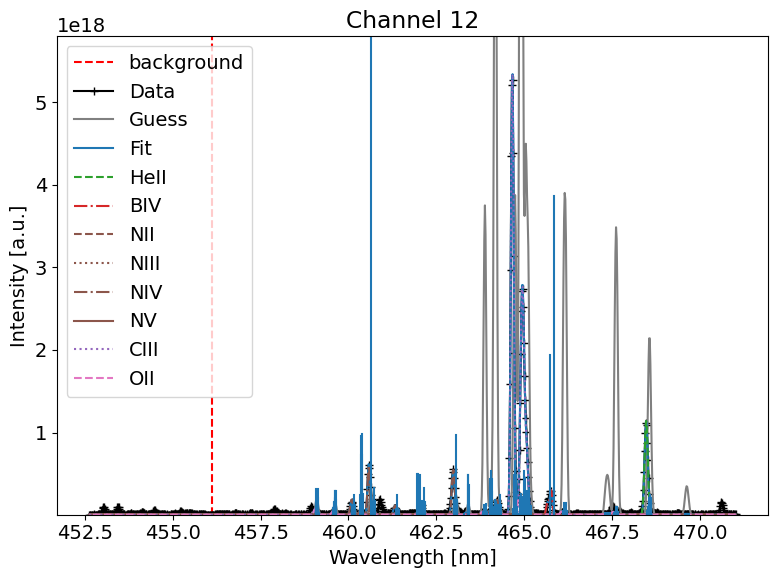

2024-02-15 19:50:11,121 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.409362778058295, 16.159753806781474, 16.758317231127887, 16.81562344294661, 16.085316928456272, 15.459287689485459, 18.36355304086852, 16.518089361871304, 19.10807861044707]
2024-02-15 19:50:11,123 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826, 14.20745818695826]
2024-02-15 19:50:11,124 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144, 20.079305541816144]


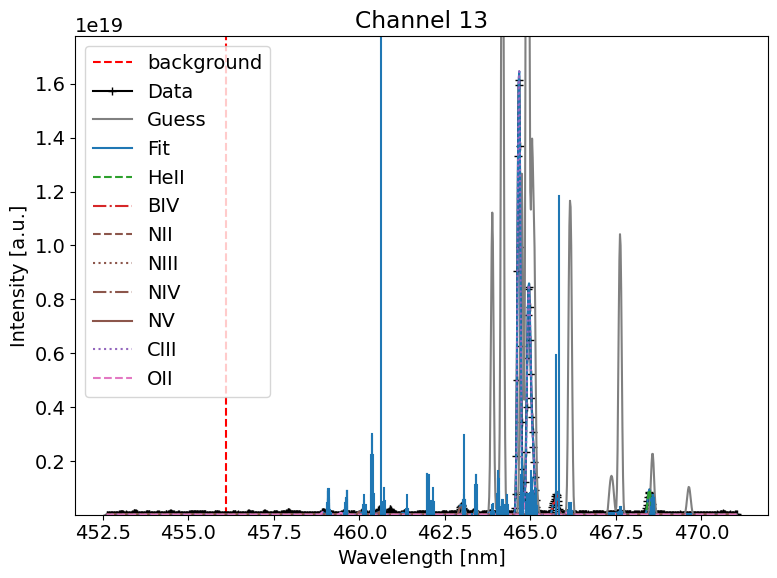

2024-02-15 19:50:20,979 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.011301963010034, 16.247045767750688, 17.3274498601891, 17.084144119490627, 16.617881123305725, 16.212839048902076, 18.61444731315491, 16.86040299071107, 19.34654175520038]
2024-02-15 19:50:20,980 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124, 14.48003692851124]
2024-02-15 19:50:20,981 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146, 20.322079834425146]


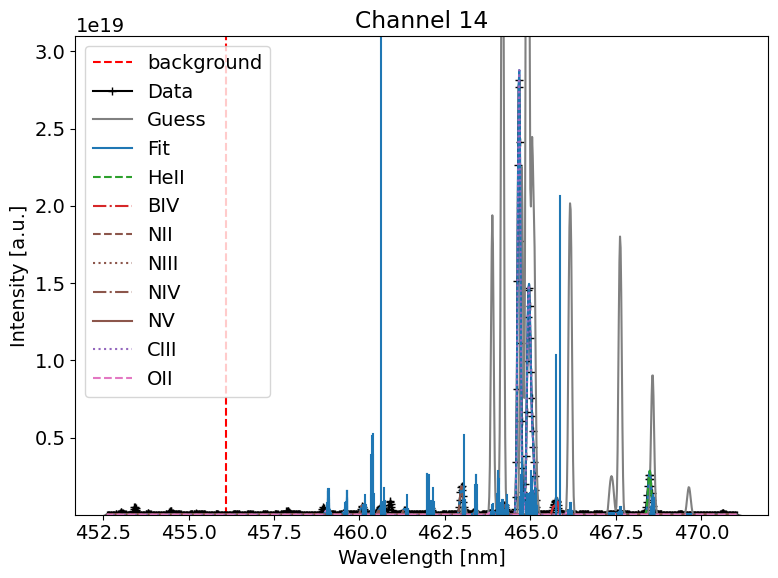

2024-02-15 19:50:29,141 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.549889348591925, 16.27022955483882, 16.703494957556554, 16.70823109262146, 16.097805298113823, 15.899331352109506, 18.31634745553658, 16.55164106896693, 19.045188311354366]
2024-02-15 19:50:29,143 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566, 14.16993279248566]
2024-02-15 19:50:29,145 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043, 20.020825225311043]


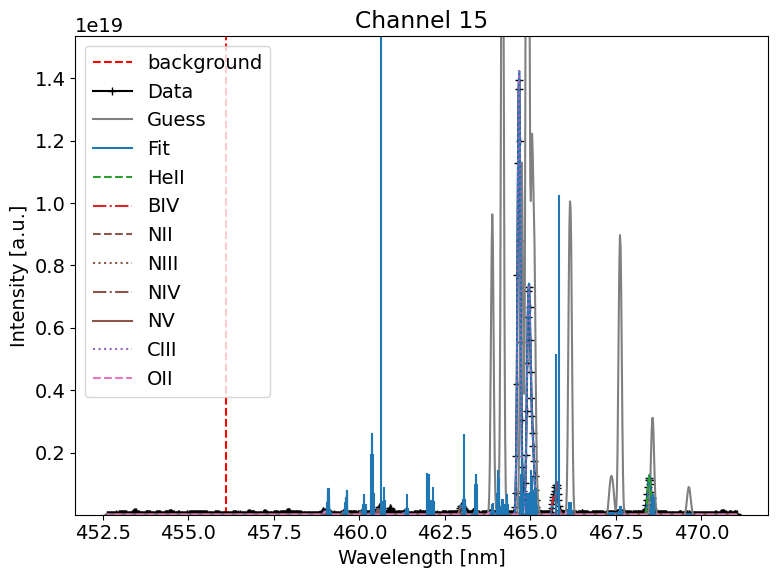

2024-02-15 19:50:47,415 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.75576626791627, 16.366890449294335, 16.746473009701198, 16.707189106891246, 16.15051766525757, 16.079855532178925, 18.370951837872582, 16.528479970482806, 19.0222025357494]
2024-02-15 19:50:47,417 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814, 14.180617822906814]
2024-02-15 19:50:47,418 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223, 20.018613024725223]


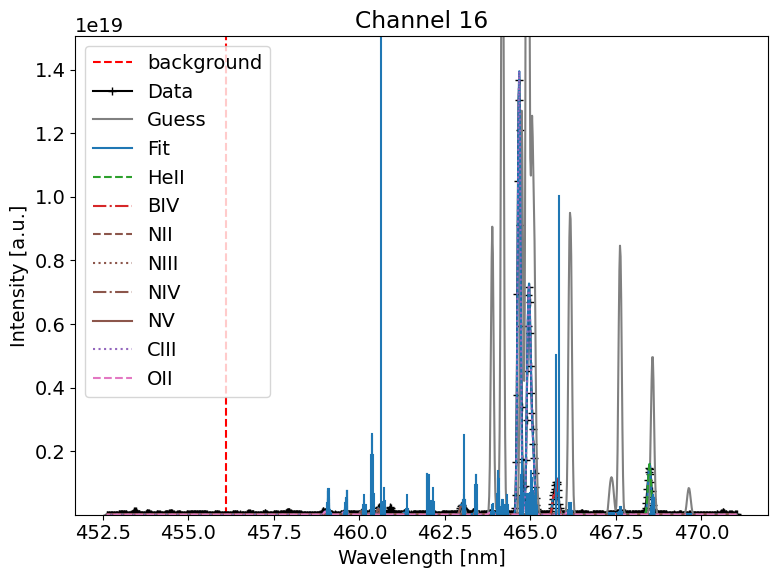

2024-02-15 19:51:05,324 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.66497065342836, 16.38352775536049, 16.62819028819303, 16.555634275397182, 16.08173459148734, 15.87451267077458, 18.303228578568753, 16.480278829736957, 18.912691731993892]
2024-02-15 19:51:05,326 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685, 14.0910416269685]
2024-02-15 19:51:05,328 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866, 19.91932466125866]


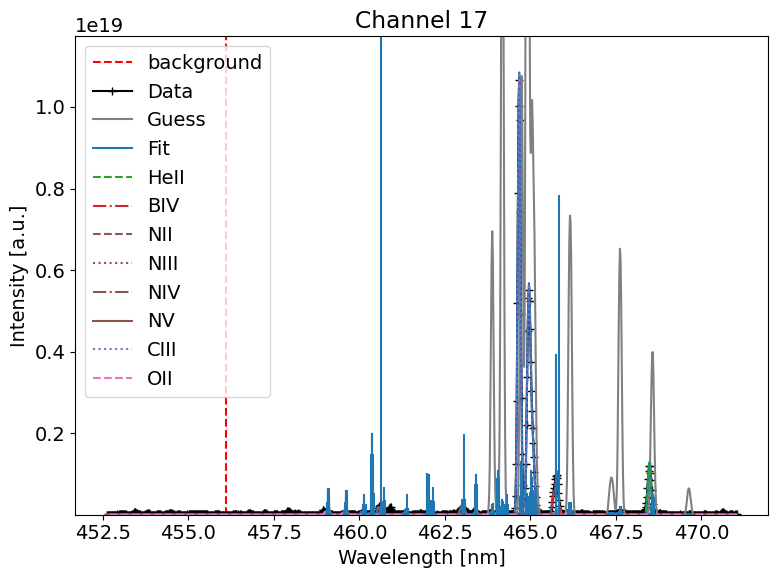

2024-02-15 19:51:21,142 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 17.901972821529338, 16.523779514248474, 16.736468597904448, 16.551366298615342, 16.195796607839466, 16.200251392542793, 18.417975150712238, 16.49794676395397, 18.92727572734233]
2024-02-15 19:51:21,144 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623, 14.143908194493623]
2024-02-15 19:51:21,145 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133, 19.955386825236133]


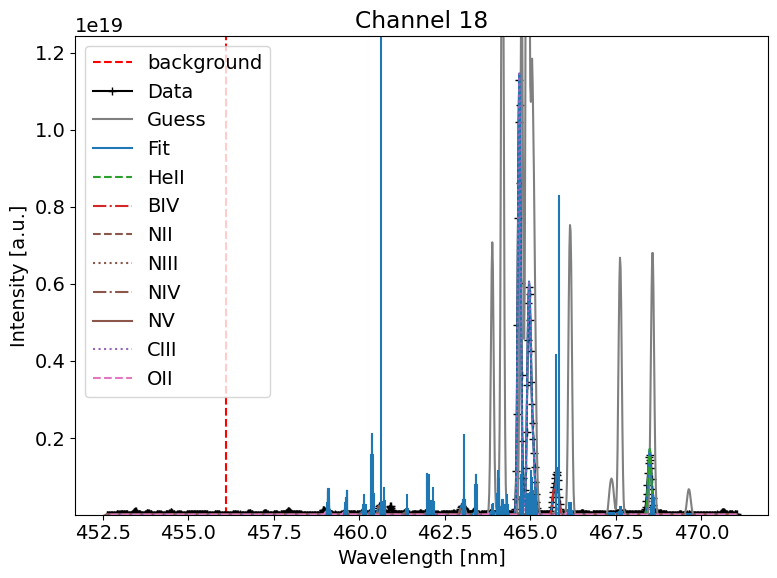

2024-02-15 19:51:33,549 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.230251935371932, 16.67795933671045, 16.963875850452293, 16.677509145652785, 16.39477199925238, 16.48144939907598, 18.623785198643663, 16.692839394725908, 19.027314124632035]
2024-02-15 19:51:33,551 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306, 14.281481230554306]
2024-02-15 19:51:33,552 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734, 20.078300713616734]


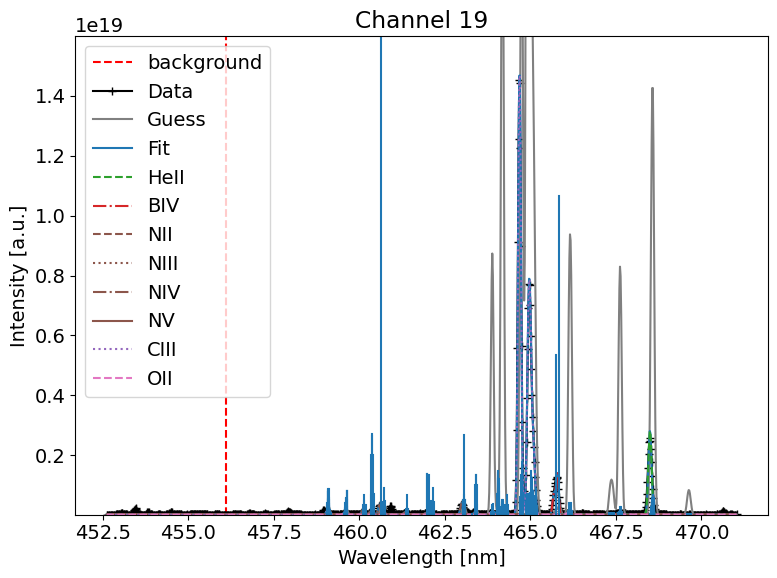

2024-02-15 19:51:44,248 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.258529610265004, 16.77148287681044, 16.876361209027923, 16.59678097418545, 16.34366489230117, 16.517078737257854, 18.624015772826166, 16.63224122223813, 18.911806657052033]
2024-02-15 19:51:44,249 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209, 14.22084556452209]
2024-02-15 19:51:44,250 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142, 20.003874038330142]


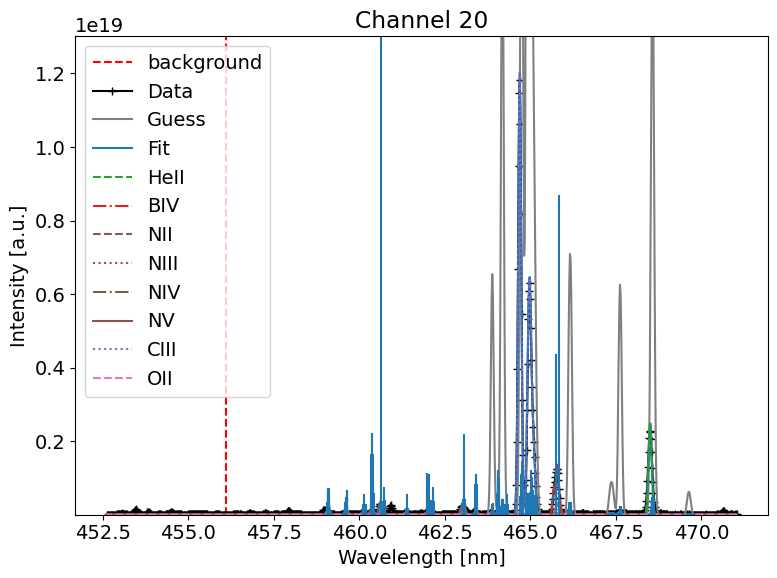

2024-02-15 19:51:51,846 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.44604306908838, 16.9051200682503, 17.013644073740846, 16.619051097945125, 16.43415026941382, 16.644264978579017, 18.73578077891111, 16.77335314104855, 18.890850337488704]
2024-02-15 19:51:51,847 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342, 14.264853261586342]
2024-02-15 19:51:51,848 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327, 20.027745821004327]


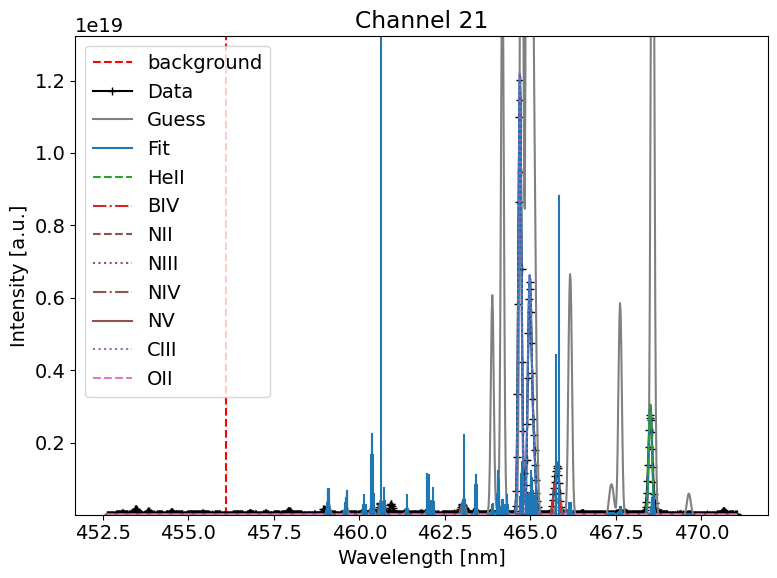

2024-02-15 19:51:59,857 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.663654727173864, 17.036299418138956, 17.091540928020585, 16.71471437761304, 16.509617871158298, 16.769739396637927, 18.839171210442164, 16.872186551215915, 18.862137618449818]
2024-02-15 19:51:59,858 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825, 14.315905262716825]
2024-02-15 19:51:59,859 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612, 20.04793491552612]


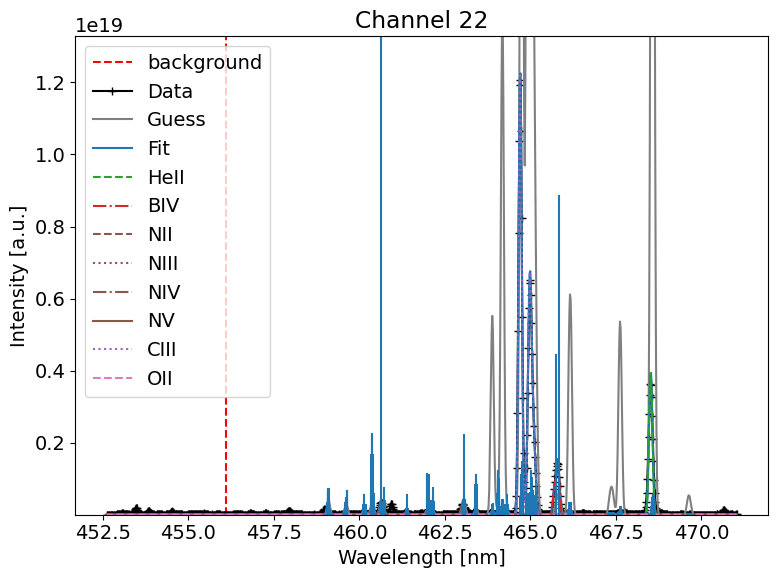

2024-02-15 19:52:07,454 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.818764314395835, 17.128000324146058, 17.189647070952656, 16.730355116961995, 16.537696957224636, 16.83229057568106, 18.907292777176725, 16.91700515947302, 18.79758093467641]
2024-02-15 19:52:07,456 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233, 14.340371245062233]
2024-02-15 19:52:07,457 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876, 20.050126830868876]


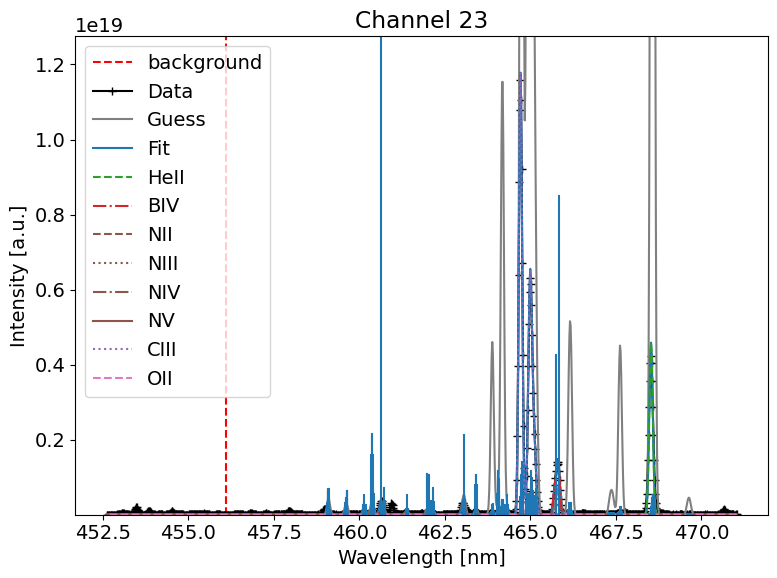

2024-02-15 19:52:15,178 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.84858498692791, 17.08737939412572, 17.20400738885527, 16.72809944941411, 16.488392827432847, 16.810360424324276, 18.867534091417678, 16.95953567912899, 18.72554773865068]
2024-02-15 19:52:15,181 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124, 14.308037204256124]
2024-02-15 19:52:15,182 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497, 19.982180942484497]


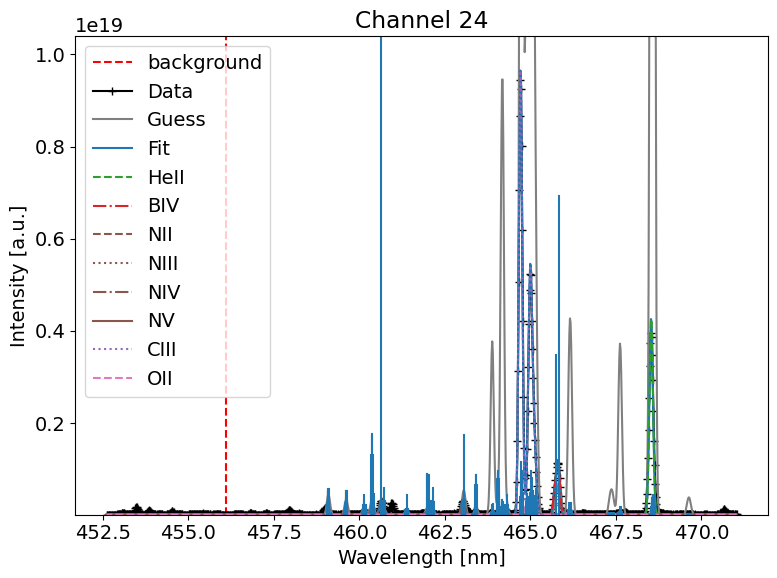

2024-02-15 19:52:23,195 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.92302533472363, 17.13137493257232, 17.271114157649816, 16.693829722692655, 16.42630084404711, 16.84986409511483, 18.91654092619842, 17.019033983649354, 18.64865212081163]
2024-02-15 19:52:23,198 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396, 14.326941070492396]
2024-02-15 19:52:23,199 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053, 19.9871719928053]


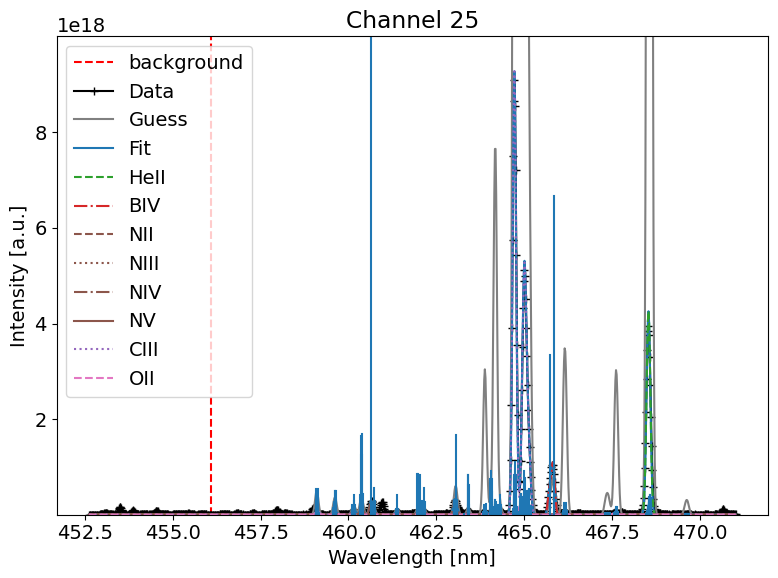

2024-02-15 19:52:30,697 - divertor_spectroscopy.analysis - DEBUG - guess [461.9, -0.018, -3.063141428685387e-07, 18.612784541595815, 16.812406380905603, 17.24712972271071, 16.589149219591267, 16.141285050625054, 16.53286601337761, 18.694195822023833, 16.915144171939033, 18.464946579222595]
2024-02-15 19:52:30,699 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [460, -0.0195, -1e-06, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072, 14.129700230663072]
2024-02-15 19:52:30,701 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [463, -0.017, 1e-06, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858, 19.754267571904858]


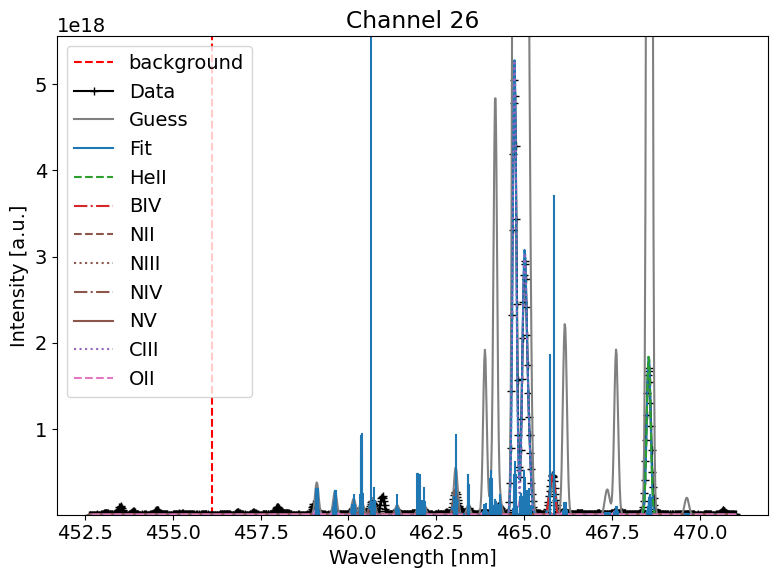

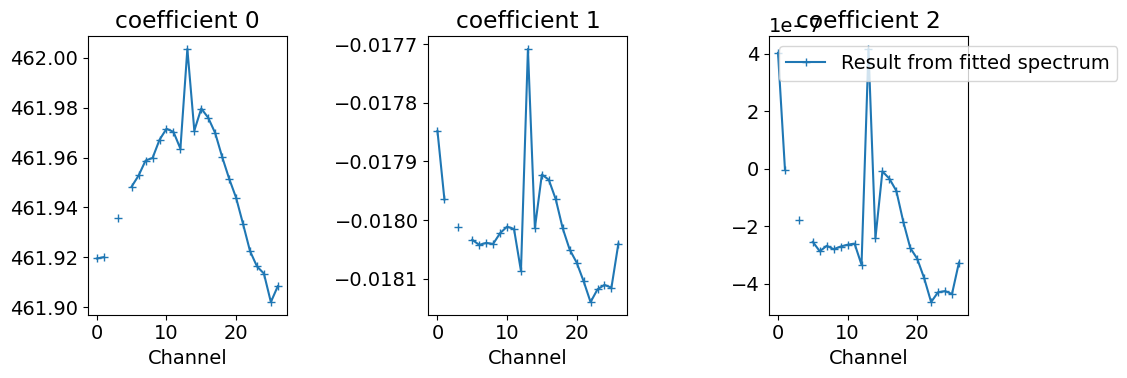

In [16]:
#%matplotlib widget
wavelength_coefficients_guess = [461.9, -0.018, -3.063141428685387e-07]
lower_bounds_wl = [460,-0.0195,-1e-6]
upper_bounds_wl = [463,-0.017,1e-6] 
importlib.reload(wavelength_calibration)
wavelength_calibration.calibrate_spectrometer_using_datasource_qss_class(instrument_function_mode=instrument_function_mode,ds_qss=ds_qss,model=model,wavelength_coefficients_guess=wavelength_coefficients_guess,lower_bounds_wl=lower_bounds_wl,upper_bounds_wl=upper_bounds_wl,wcal=wcal,signal_type=signal_type,save_wavelength_calibration=save_wavelength_calibration,comment=wcal_comment,fit_coefficients=fit_coefficients,exclude_saturation_in_wl_calibration=exclude_saturation_in_wl_calibration,debug=debug)
    

### This wavelength calibration was done without Stark broadening - so let's reload the model fou you to play around with

In [ ]:
if True:
    reduced = False
    if reduced:
        from divertor_spectroscopy.spectrum_models import ip320_cw_405_reduced_Balmer_delta
        importlib.reload(ip320_cw_405_reduced_Balmer_delta)
        zeeman = zeeman
        stark_density = True
        debug = True
        model = ip320_cw_405_reduced_Balmer_delta.Ip320_cw_405_reduced_Balmer_delta(zeeman=zeeman,stark_density=stark_density,debug=debug)
    else:
        from divertor_spectroscopy.spectrum_models import ip320_cw_462
        importlib.reload(ip320_cw_462)
        zeeman = True
        stark_density = True
        debug = True
        model = ip320_cw_462.Ip320_cw_462(zeeman=zeeman,stark_density=stark_density,debug=debug)

### Cell for playing around with the spectrum

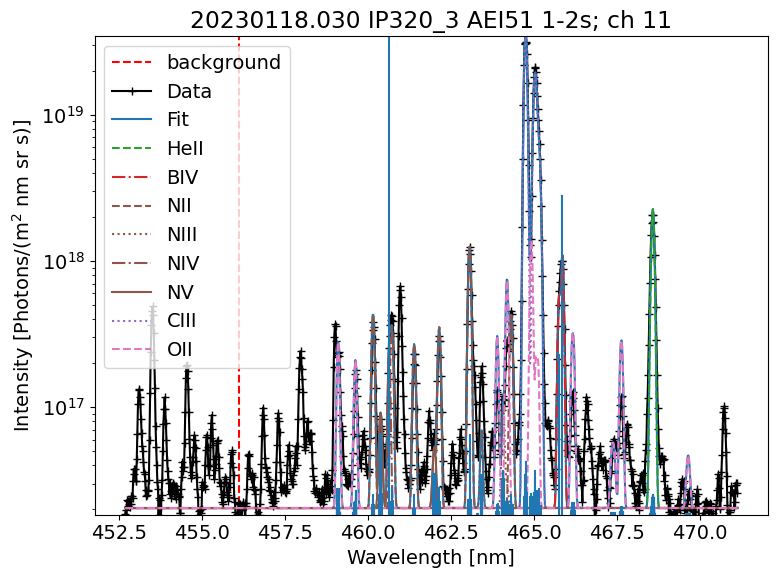

fit_description  fit_parameters  fit_parameters_linear      guess  \
0  Intensity_HeII_468.571       17.401260           2.519183e+17  18.566041   
1   Intensity_BIV_465.817       17.174074           1.493050e+17  16.985515   
2   Intensity_NII_462.324       17.495269           3.128017e+17  17.741568   
3  Intensity_NIII_463.855       16.120086           1.318517e+16  16.881171   
4   Intensity_NIV_460.633       16.283369           1.920300e+16  16.246537   
5    Intensity_NV_460.915       16.067235           1.167441e+16  16.382156   
6  Intensity_CIII_464.881       18.838482           6.894172e+18  19.328490   
7   Intensity_OII_459.320       16.636705           4.332167e+16  17.459901   
8   Intensity_OII_465.154       17.518980           3.303542e+17  18.391497   

   lower_bounds  upper_bounds  
0     14.576804     20.371767  
1     14.576804     20.371767  
2     14.576804     20.371767  
3     14.576804     20.371767  
4     14.576804     20.371767  
5     14.576804     20.371767  
6     14.576804     20.371767  
7     14.576804     20.371767  
8     14.576804     20.371767

In [ ]:
#%matplotlib widget
signal_type = "signal_photons"
#signal_type = "signal_counts"
importlib.reload(analysis)
t = 1
t_to = 2#experiment_length
c_idx = 11

wavelength=ds_qss.data["wavelength_nm"][c_idx]
width = ds_qss.instrument_function[c_idx]*(np.abs(wavelength[0]-wavelength[-1])/len(wavelength))
numeric_instrument_function = ds_qss.numeric_instrument_function[c_idx]
inst = instrument.Instrument(wavelength=wavelength,width=width,instrument_function_mode=instrument_function_mode,numeric_instrument_function=numeric_instrument_function)
analyse = analysis.Analysis(model=model,instrument=inst)
t_idx = utils.val2idx(ds_qss.data["time_s"],t)
t_idx_to = utils.val2idx(ds_qss.data["time_s"],t_to)
debug = True
xlim = [409.5,410.5]
xlim = None

background_position = model.recommended_background_position
highlight_tags = model.all_tags
show_fit = False
experiment_data=np.nanmean(ds_qss.data[signal_type][t_idx:t_idx_to+1,c_idx],0)
active_spectrum = False
if active_spectrum:
    t_background = 0.5
    t_background_to = 1
    t_background_idx = utils.val2idx(ds_qss.data["time_s"],t_background)
    t_background_idx_to = utils.val2idx(ds_qss.data["time_s"],t_background_to)    
    background_spectrum = np.nanmean(ds_qss.data[signal_type][t_background_idx:t_background_idx_to+1,c_idx],0)
    experiment_data = experiment_data-background_spectrum
analyse.fit_spectrum(experiment_data=experiment_data)
show_positions = True
scale = scale
title = pid + " " + camid + " " + port + " " + str(t) + "-"+str(t_to)+ "s; ch " + str(c_idx)
#title = pid + " " + camid + " " + port + " " + str(t) + "-"+str(t_to)+ "s; ch " + str(c_idx) + " Stark: {:.1e}".format(10**analyse.fit_parameters[-3])
analyse.display_spectrum(highlight_tags=highlight_tags,show_positions=show_positions,guess=False,xlim=xlim,ylabel=intensity_label,title=title,scale=scale)
# debugging option: I want to debug a given line with a given parameter: 
if False: 
    debug_tags = ["HI","HI"]
    debug_fit_parameters = []
    fit_parameters_lower = copy.deepcopy(analyse.fit_parameters)
    fit_parameters_lower[-3] = np.log10(10**fit_parameters_lower[-3]*0.5)
    fit_parameters_lower[-1] = np.log10(10**fit_parameters_lower[-1]*0.5)
    print(fit_parameters_lower)
    debug_fit_parameters.append(fit_parameters_lower)
    fit_parameters_upper = copy.deepcopy(analyse.fit_parameters)
    fit_parameters_upper[-3] = np.log10(10**fit_parameters_upper[-3]*1.5)
    fit_parameters_upper[-1] = np.log10(10**fit_parameters_upper[-1]*1.5)
    print(fit_parameters_upper)
    debug_fit_parameters.append(fit_parameters_upper)
    analyse.display_spectrum(debug_tags=debug_tags,debug_fit_parameters=debug_fit_parameters,highlight_tags=highlight_tags,show_positions=show_positions,guess=False,xlim=xlim,ylabel=intensity_label,title=title,scale=scale)
analyse.format_fit_output()
analyse.fit_output

In [ ]:
asdf

NameError: name 'asdf' is not defined

### I will give two default ways of analysing a discharge:
- fitting a profile
- fitting the maximum channel per strikeline

### Cell to fit a profile:
- todo: think about input of times

In [ ]:
#%matplotlib widget
if False:
    importlib.reload(analysis)
    channels = np.arange(27)
    analysis_start_profil = 9
    analysis_end_profil = 10
    analysis_step_profil = 1
    debug=True
    xlim = [409.5,410.5]
    #xlim = [396.5,397.5]
    profil = analysis.fit_profile(instrument_function_mode=instrument_function_mode,numeric_instrument_function=ds_qss.numeric_instrument_function,model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,channels=channels,signal_type=signal_type,analysis_start=analysis_start_profil,analysis_end=analysis_end_profil,analysis_step=analysis_step_profil,debug=debug)

In [ ]:
if False:
    if camid == "IP320_2" or camid == "IP320_4":
        parameters = ['Stark_density_H_delta', "Intensity_H_delta",'Stark_density_H_epsilon', "Intensity_H_epsilon"] # parameters you want to display
        #parameters = ["Intensity_ArII_401.386","Intensity_NII_399.500","Intensity_H_delta"]
    if camid == "IP320_1":
        parameters = ["Intensity_CIII_360.934"]
        parameters = ['Intensity_NeII 3s2P-3p2D_371.315',
    'Intensity_NeII 3s4P-3p4P_371.046',
    'Intensity_NeII 3s2D-3p2F_357.111',]
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    plt.title(
        "12.3° {} {} {} {} - {} s".format(camid, pid, port, analysis_start_profil,analysis_end_profil))
    for parameter in parameters:
        if "Intensity" in parameter:
            ax2.plot(channels,10**profil["fit_parameters"][parameter][0], c=colors[parameters.index(parameter)],marker="+",label=parameter)
        else:
            ax1.plot(channels[:16],10**profil["fit_parameters"][parameter][0][:16], c=colors[parameters.index(parameter)],marker="+",label=parameter)
            
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.set_xlabel("Time [s]")
    plt.gca().set_ylim(bottom=0)
    # Add arrow pointing to the left
    plt.arrow(0.6, 0.2, -0.1, 0, head_width=0.05, head_length=0.05, fc='red', ec='red', width=0.02,
        transform=plt.gca().transAxes)
    if port[:3]=="AEF":
        plt.text(0.2, 0.19, 'Horizontal Target', fontsize=12, color='red',
        transform=plt.gca().transAxes)
    if port[:3]=="AEI":
        plt.text(0.2, 0.19, 'Divertor Target', fontsize=12, color='red',
        transform=plt.gca().transAxes)
    # Add arrow pointing right
    plt.arrow(0.65, 0.2, 0.1, 0, head_width=0.05, head_length=0.05, fc='blue', ec='blue', width=0.02,
            transform=plt.gca().transAxes)
    if port[:3]=="AEF":
        plt.text(0.8, 0.19, 'Vertical Target', fontsize=12, color='blue',
            transform=plt.gca().transAxes)
    if port[:3]=="AEI":
        plt.text(0.8, 0.19, 'Confined Plasma', fontsize=12, color='blue',
            transform=plt.gca().transAxes)
    #ax1.set_ylim(0.6e20,1.7e20)
    #ax2.set_ylim(0,1.3e17)
    plt.legend()
    plt.show()

### Fitting entire discharge at max intensity per strikeline

In [ ]:
importlib.reload(analysis)
output = {}
debug = False
output["instrument_function_mode"] = instrument_function_mode
utils.create_folder(save_path+"Plots/")
xlim = [409.5,410.5]
save_path_plots = save_path+"Plots/" 
show_positions = True
for strikeline in strikelines:
    output[strikeline] = analysis.fit_discharge_brightest_channel(instrument_function_mode=instrument_function_mode,numeric_instrument_function=ds_qss.numeric_instrument_function,debug=debug,highlight_tags=model.all_tags,model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,exclude_channels=exclude_channels,strikeline=strikeline,strongest_line=strongest_line,signal_type=signal_type,analysis_start=analysis_start,analysis_end=analysis_end,analysis_step=analysis_step,save_path=save_path_plots) 

2024-02-12 18:07:14,077 - divertor_spectroscopy.utilities - DEBUG - Folder '//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/20230117/20230117.051/Plots/' created successfully.


\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\analysis.py:80: RuntimeWarning: invalid value encountered in log10
  intensity_guess = np.log10((experiment_data[position_idx] - self.background_guess)/m.branching_ratios[dominant_idx] *self.instrument.width * np.sqrt(2 * np.pi))
2024-02-12 18:07:18,562 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:21,499 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:26,891 - divertor_spectroscopy.analysis - INFO - Progress: 50%
2024-02-12 18:07:26,901 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:32,259 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:34,976 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:37,507 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-02-12 18:07:42,984 - 

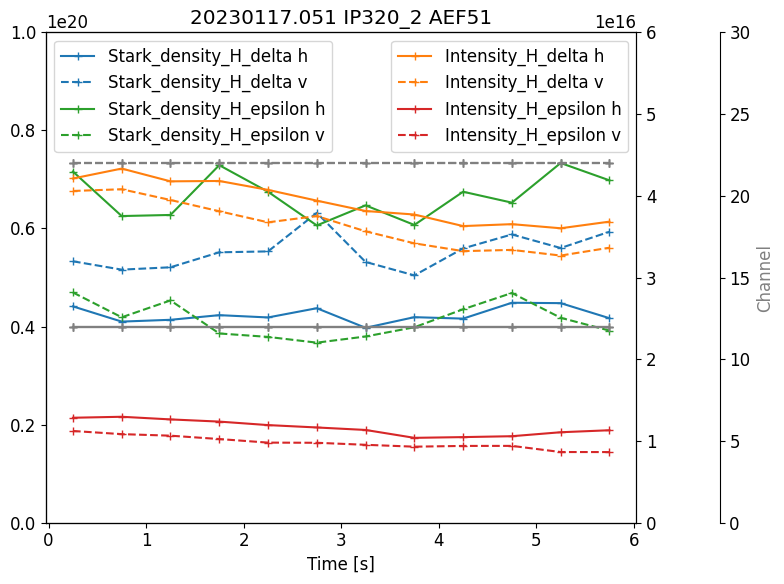

In [ ]:
#%matplotlib widget
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
parameters = ['Stark_density_H_delta', "Intensity_H_delta",'Stark_density_H_epsilon', "Intensity_H_epsilon"] # parameters you want to display
#parameters = ['Stark_density_H_delta', "Intensity_H_delta"]
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
for parameter in parameters:
    for strikeline in strikelines:
        if "density" in parameter:
            ax1.plot(output[strikeline]["time"],10**output[strikeline]["fit_parameters"][parameter],ls=ls[strikeline],marker="+",c=colors[parameters.index(parameter)],label=parameter+" "+strikeline[0])
        if "Intensity" in parameter:
            ax2.plot(output[strikeline]["time"],10**output[strikeline]["fit_parameters"][parameter],ls=ls[strikeline],marker="+",c=colors[parameters.index(parameter)],label=parameter+" "+strikeline[0])
        ax3.plot(output[strikeline]["time"],output[strikeline]["channels"],ls=ls[strikeline],marker="+",c="grey",label=strikeline[0]+" Channels")
    
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("Time [s]")
title = pid+" "+camid+" "+port
ax1.set_ylim(0,1e20)
ax2.set_ylim(0,6e16)
ax3.set_ylim(0,30)
ax3.set_ylabel("Channel",color="grey")
plt.title(title)
plt.tight_layout()
if save_fits:
    name = "Fit_of_channels_max_intensity_intensities_"+str(strongest_line)+"_"+port+"_"+str(analysis_step)+"s"
    fig.savefig(save_path+name+".png")
plt.show()

if save_fits:
    json.dump(output, codecs.open(save_path+"{}.json".format(name), 'w', encoding='utf-8'),
            cls=utils.NumpyEncoder, separators=(',', ':'), sort_keys=False, indent=4)     

In [ ]:
asdf

NameError: name 'asdf' is not defined

### Fitting discharge at given channels: 

In [ ]:
output_channel_1 = {}
debug = False
c_idx_fixed1 = 1
for strikeline in strikelines:
    output_channel_1[strikeline] = analysis.fit_discharge_brightest_channel(c_idx_fixed=c_idx_fixed1,debug=debug,highlight_tags=model.all_tags,model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,exclude_channels=exclude_channels,strikeline=strikeline,strongest_line=strongest_line,signal_type=signal_type,analysis_start=analysis_start,analysis_end=analysis_end,analysis_step=analysis_step) 

2024-01-18 14:10:32,224 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 14:10:32,227 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 14:10:35,929 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 14:10:35,933 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 14:10:35,935 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite


: 

In [ ]:
output_channel_2 = {}
debug = False
c_idx_fixed2 = 8
for strikeline in strikelines:
    output_channel_2[strikeline] = analysis.fit_discharge_brightest_channel(c_idx_fixed=c_idx_fixed2,debug=debug,highlight_tags=model.all_tags,model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,exclude_channels=exclude_channels,strikeline=strikeline,strongest_line=strongest_line,signal_type=signal_type,analysis_start=analysis_start,analysis_end=analysis_end,analysis_step=analysis_step) 

2024-01-18 13:52:17,923 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:21,217 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:22,958 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:24,723 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:24,727 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:26,539 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:26,541 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:29,776 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:29,779 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:29,781 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-18 13:52:29,782 - divertor_spectroscopy.analysis - D

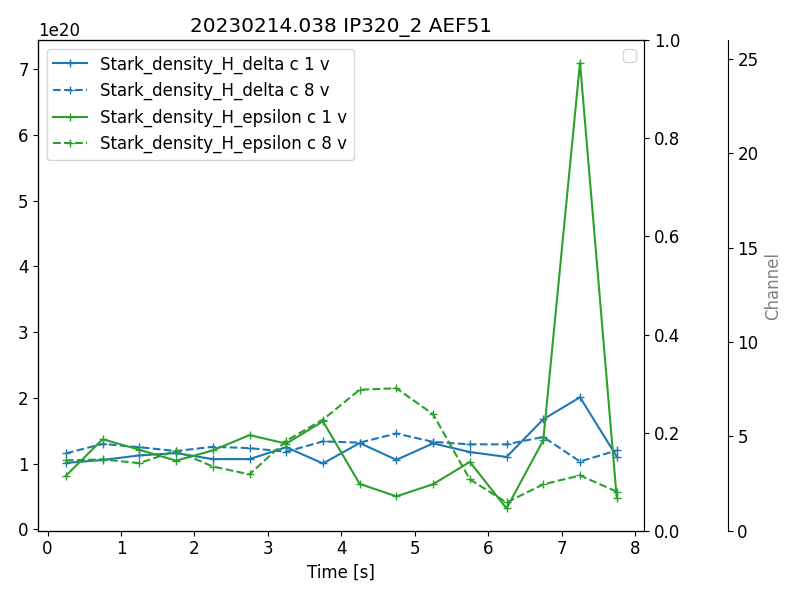

In [ ]:
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
parameters = ['Stark_density_H_delta', "Intensity_H_delta",'Stark_density_H_epsilon', "Intensity_H_epsilon"] # parameters you want to display
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
for parameter in parameters:
    for strikeline in strikelines:
        if "density" in parameter:
            ax1.plot(output_channel_1[strikeline]["time"],10**output_channel_1[strikeline]["fit_parameters"][parameter],ls="-",marker="+",c=colors[parameters.index(parameter)],label=parameter+" c "+str(c_idx_fixed1)+" "+strikeline[0])
            ax1.plot(output_channel_2[strikeline]["time"],10**output_channel_2[strikeline]["fit_parameters"][parameter],ls="--",marker="+",c=colors[parameters.index(parameter)],label=parameter+" c "+str(c_idx_fixed2)+" "+strikeline[0])
        #if "Intensity" in parameter:
        #    ax2.plot(output[strikeline]["time"],10**output[strikeline]["fit_parameters"][parameter],ls=ls[strikeline],marker="+",c=colors[parameters.index(parameter)],label=parameter+" "+strikeline[0])
    
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("Time [s]")
title = pid+" "+camid+" "+port
#ax1.set_ylim(0,6)
#ax2.set_ylim(0,2)
ax3.set_ylim(0,26)
ax3.set_ylabel("Channel",color="grey")
plt.title(title)
plt.tight_layout()
plt.show()